In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


**Goal**
* See why customers are churning
* How to stop customers from churning (retention)
* Predict customers likely to churn

**Useful insights**
* Lost revenue due to customers churning
* Revenue gained in x time from current customers not churning

In [3]:
pd.set_option('colwidth', None)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

In [4]:
# import data
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
# Inital EDA
print(df.shape)
print('\n')
print(df.describe())
print('\n')
print(df.info())
print('\n')
print(df.isnull().sum())
print('\n')
print(df.nunique())

(7043, 21)


       SeniorCitizen  tenure  MonthlyCharges
count        7043.00 7043.00         7043.00
mean            0.16   32.37           64.76
std             0.37   24.56           30.09
min             0.00    0.00           18.25
25%             0.00    9.00           35.50
50%             0.00   29.00           70.35
75%             0.00   55.00           89.85
max             1.00   72.00          118.75


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8 

No null values.. There are a few columns with less than 5 unique values. These can probably be used as features in the model. Let's see what the unique values are

In [6]:
# See what the unique values for columns with 4 or less unique values
for col in df.loc[:, df.nunique() <= 4].columns:
    print(col)
    print(df[col].unique())
    print(df[col].value_counts())
    print('\n')

gender
['Female' 'Male']
Male      3555
Female    3488
Name: gender, dtype: int64


SeniorCitizen
[0 1]
0    5901
1    1142
Name: SeniorCitizen, dtype: int64


Partner
['Yes' 'No']
No     3641
Yes    3402
Name: Partner, dtype: int64


Dependents
['No' 'Yes']
No     4933
Yes    2110
Name: Dependents, dtype: int64


PhoneService
['No' 'Yes']
Yes    6361
No      682
Name: PhoneService, dtype: int64


MultipleLines
['No phone service' 'No' 'Yes']
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64


InternetService
['DSL' 'Fiber optic' 'No']
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64


OnlineSecurity
['No' 'Yes' 'No internet service']
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64


OnlineBackup
['Yes' 'No' 'No internet service']
No                     3088
Yes                    2429
No internet service    152

In [7]:
# Total charges should be float value
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce', downcast='float')

In [8]:
# See what the null values are
print(df.TotalCharges.isna().sum())
print('\n')
df.loc[df.TotalCharges.isna()]

11




,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


11 rows of NaN TotalCharges. These rows can be dropped so the dataset doesn't negatively affect the analysis. This drop affects less than 1% of the dataset

In [9]:
# Drop NAs
df.dropna(axis=0,
          how='any',
          subset=['TotalCharges'],
          inplace=True)

print(df.isna().sum()) # should be 0

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [10]:
# Change datatype to match with MonthlyCharges
df['TotalCharges'] = df.TotalCharges.astype(float)
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [11]:
# Change values to Yes or No like the other columns
df['SeniorCitizen'] = np.select(condlist=[df.SeniorCitizen == 0, df.SeniorCitizen == 1], 
                                choicelist=['No', 'Yes'])

df['SeniorCitizen'].unique()

array(['No', 'Yes'], dtype=object)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

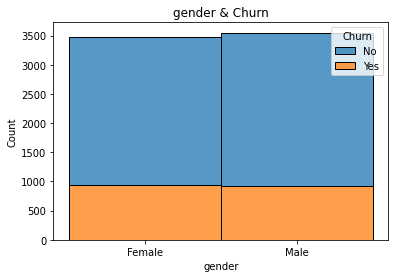

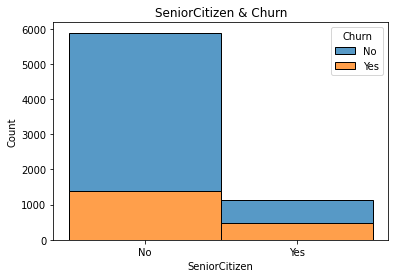

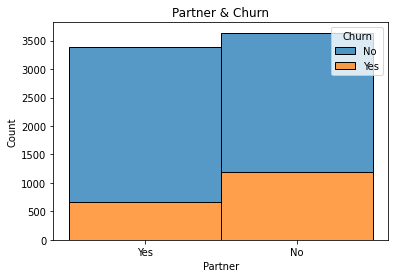

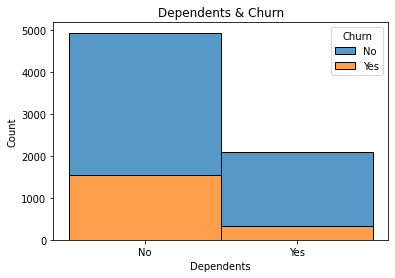

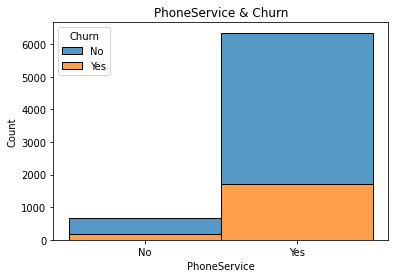

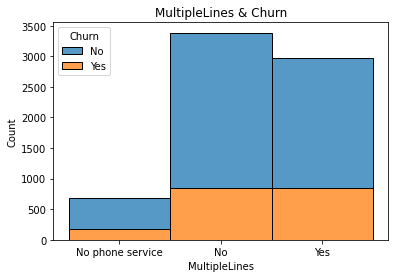

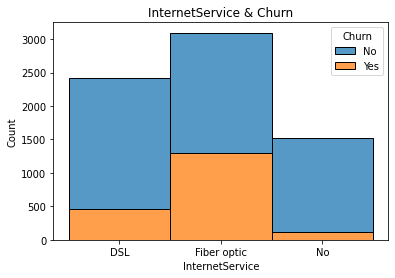

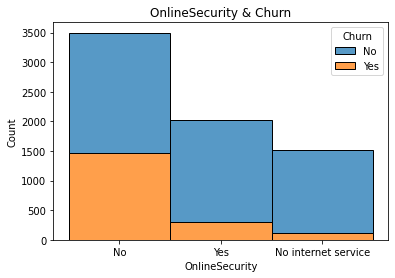

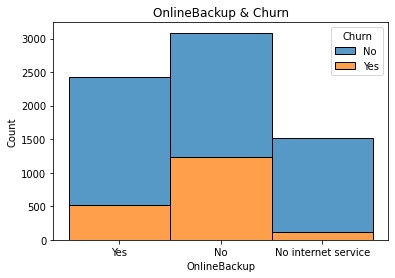

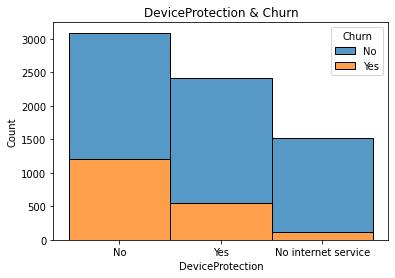

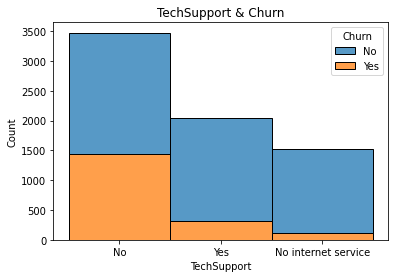

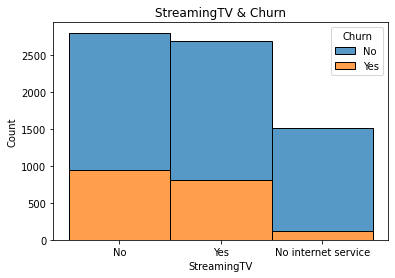

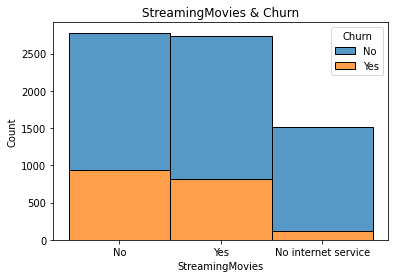

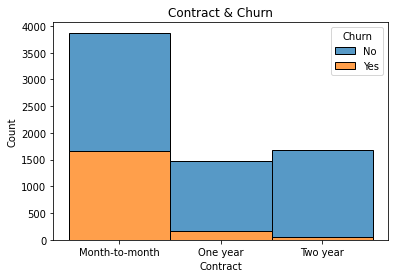

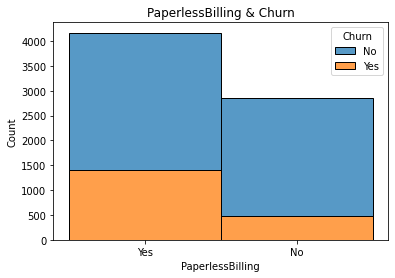

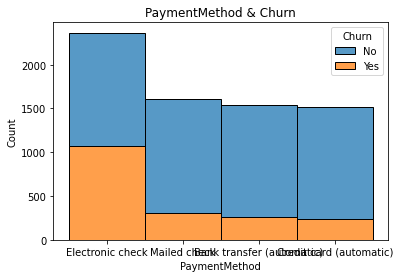

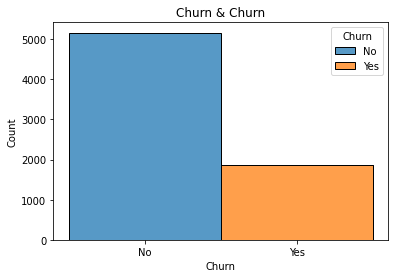

In [13]:
# See all features with 4 or less unique values and its relationship with customers churning
for i, col in enumerate(df.loc[:, df.nunique() <= 4].columns):
    plt.figure(i)
    sns.histplot(x=col, data=df, hue='Churn', multiple='stack').set_title(col+' & Churn')

Customers with added a particular set of services (Online Security, Online Backup, Tech Support, Device Protection) are **less likely to churn**

Customers with more flexibility (no partner, not dependent, month-to-month contract) are **more likely to churn**

Customers with streaming are **more likely to churn**. Most likely bc many streaming services do not have every movie or TV show packaged, so it makes customers more likely to hop around streaming services

Customers with Electronic Payments, Fiber Optic Internet, and Paperless Billing are **more likely to churn**

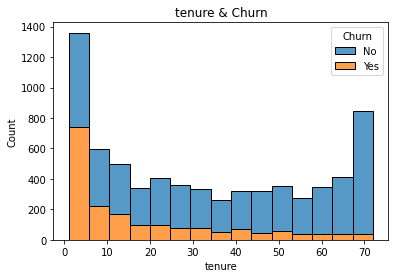

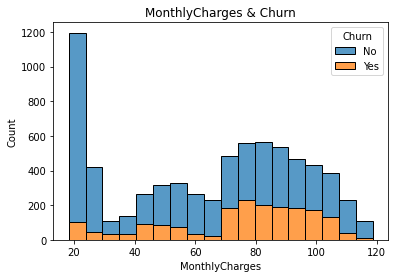

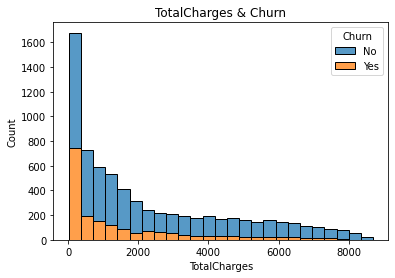

In [14]:
# Let's see how charges and tenure are affecting customer churn
for i, col in enumerate(df.select_dtypes(include=['int64','float64']).columns):
    plt.figure(i)
    sns.histplot(x=col, data=df, hue='Churn', multiple='stack').set_title(col+' & Churn')

Customers churn early, indicated by the high churn rate in Total Charges and Tenure in the lower tail of the distribution

Customers are likely to churn when their monthly rates are ~ $70 to 110

In [15]:
# How much money has been made from customers churning vs not
df.groupby('Churn').agg({'TotalCharges':'sum', 'tenure':'mean', 'MonthlyCharges':'mean'})

,TotalCharges,tenure,MonthlyCharges
Churn,,,
No,13193241.81,37.65,61.31
Yes,2862926.90,17.98,74.44


It seems customers that churn are getting charged more in total and monthly than charges of customers that do not churn

In [16]:
from sklearn.preprocessing import LabelEncoder

In [17]:
# Encode categorical variables and change column type to category
lb = LabelEncoder()
for col in df.loc[:, df.nunique() <= 4].columns:
    df[col] = lb.fit_transform(df[col])
    df[col] = df[col].astype('category')

In [18]:
from sklearn.preprocessing import MinMaxScaler

In [19]:
# Normalize data
scaler = MinMaxScaler()
df[df.select_dtypes(include=['int64','float64']).columns] = scaler.fit_transform(df.select_dtypes(include=['int64','float64']))

In [20]:
from autosklearn.classification import AutoSklearnClassifier

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [22]:
# Split data into X and y
X = df.iloc[:, 1:-1] # The numeric and categorical features, excluding CustomerID and Churn
y = df.iloc[:, -1] # Churn

# Train test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

[WARNING] [2021-12-30 06:14:12,383:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 1. Number of dummy models: 1


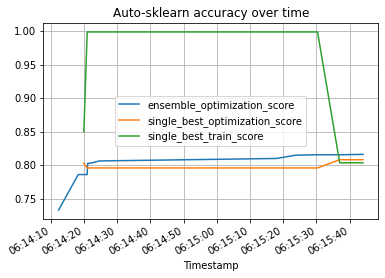

auto-sklearn results:
  Dataset name: afbc79fe-6937-11ec-80c4-0242ac130202
  Metric: accuracy
  Best validation score: 0.808000
  Number of target algorithm runs: 33
  Number of successful target algorithm runs: 21
  Number of crashed target algorithm runs: 0
  Number of target algorithms that exceeded the time limit: 12
  Number of target algorithms that exceeded the memory limit: 0

[(0.480000, SimpleClassificationPipeline({'balancing:strategy': 'weighting', 'classifier:__choice__': 'lda', 'data_preprocessor:__choice__': 'feature_type', 'feature_preprocessor:__choice__': 'liblinear_svc_preprocessor', 'classifier:lda:shrinkage': 'manual', 'classifier:lda:tol': 0.0007215763283486354, 'data_preprocessor:feature_type:categorical_transformer:categorical_encoding:__choice__': 'no_encoding', 'data_preprocessor:feature_type:categorical_transformer:category_coalescence:__choice__': 'no_coalescense', 'data_preprocessor:feature_type:numerical_transformer:imputation:strategy': 'median', 'data_pr

In [23]:
# define search
automl = AutoSklearnClassifier(time_left_for_this_task=2*60, per_run_time_limit=30, n_jobs=8)
automl.fit(X_train, y_train)
preds = automl.predict(X_test)
# Change to series and data type as category
y_preds = pd.Series(data=preds, 
                    index=y_test.index,
                    dtype='category',
                    name='ChurnPreds')

# performance
automl.performance_over_time_.plot(
    x='Timestamp',
    kind='line',
    legend=True,
    title='Auto-sklearn accuracy over time',
    grid=True,
)
plt.show()

# summarize
print(automl.sprint_statistics())
print(automl.show_models())

# evaluate best model
acc = accuracy_score(y_test, y_preds)
print("Accuracy: %.3f" % acc)

In [24]:
automl.leaderboard()

,rank,ensemble_weight,type,cost,duration
model_id,,,,,
29,1,0.20,lda,0.19,2.00
31,2,0.10,gradient_boosting,0.20,8.80
24,3,0.04,gradient_boosting,0.20,8.32
30,4,0.04,gradient_boosting,0.20,3.05
17,5,0.02,extra_trees,0.20,12.35
2,6,0.02,random_forest,0.20,14.41
21,7,0.04,extra_trees,0.21,29.54
25,8,0.48,lda,0.21,5.61
10,9,0.06,gradient_boosting,0.23,15.09


In [25]:
# Evaluate model with dataset
df['ChurnPreds'] = y_preds

# Create ConfusionMatrix
df['ConfusionMatrix'] = np.select(condlist=[(df.Churn == 1) & (df.ChurnPreds == 1), 
                                            (df.Churn == 1) & (df.ChurnPreds == 0), 
                                            (df.Churn == 0) & (df.ChurnPreds == 1), 
                                            (df.Churn == 0) & (df.ChurnPreds == 0)],
                                  choicelist=['TP', 'FP', 'FN', 'TN'],
                                  default=None)

# Customers likely to churn
print(str(df.loc[df.ConfusionMatrix == 'FN'].shape[0]) + ' customers likely to churn')
df.loc[df.ConfusionMatrix == 'FN'].head()

133 customers likely to churn


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ChurnPreds,ConfusionMatrix
181,6582-OIVSP,0,0,0,0,0.00,1,0,0,0,0,0,0,0,0,0,0,3,0.27,0.00,0,1,FN
214,2504-DSHIH,1,1,1,0,0.31,1,2,1,0,0,0,0,0,2,0,0,2,0.68,0.23,0,1,FN
219,6496-JDSSB,0,0,0,0,0.10,1,0,1,0,0,0,0,2,0,0,1,0,0.61,0.07,0,1,FN
313,2799-ARNLO,0,1,1,0,0.06,1,0,1,0,0,0,0,0,0,0,1,2,0.51,0.04,0,1,FN
389,5522-JBWMO,1,0,0,1,0.00,1,0,0,0,0,0,0,0,0,0,0,2,0.26,0.00,0,1,FN


In [26]:
# Get original dataset and bring in the ConfusionMatrix column to evaluate results
df_orig = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df_orig['ConfusionMatrix'] = df.ConfusionMatrix

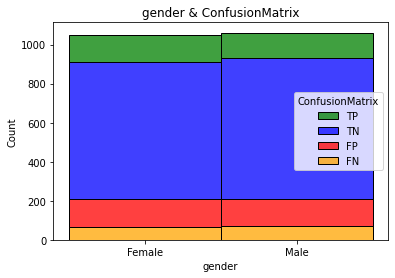

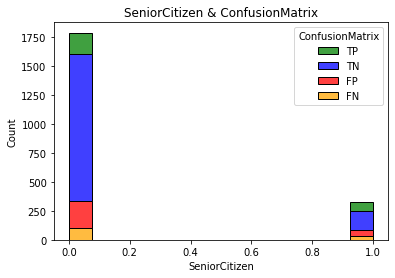

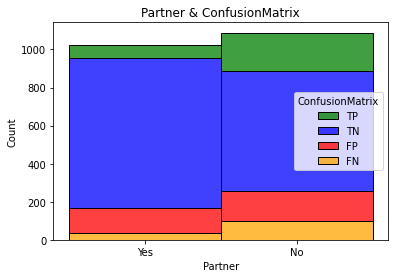

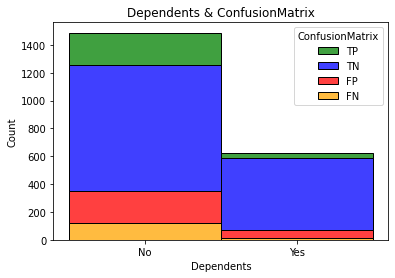

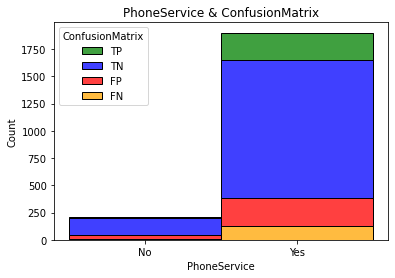

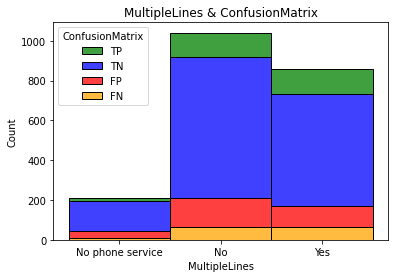

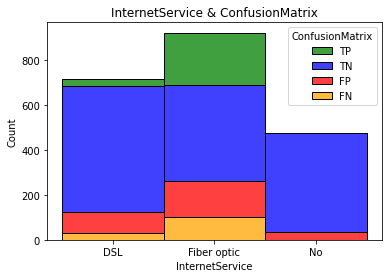

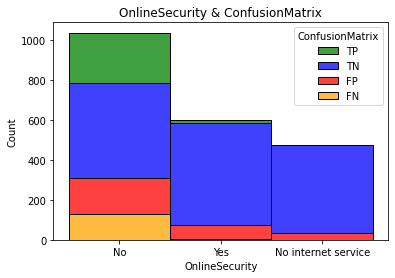

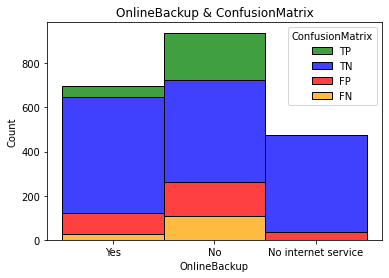

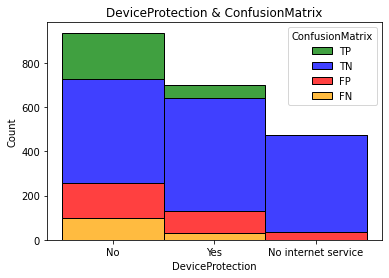

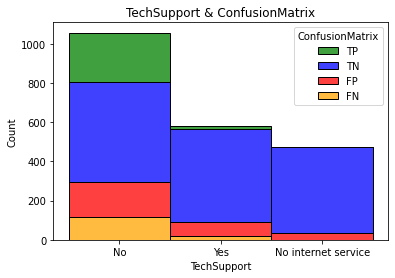

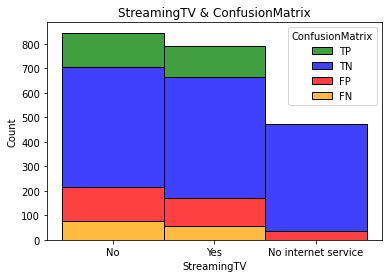

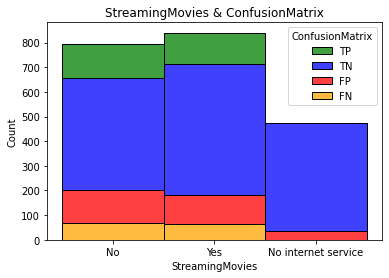

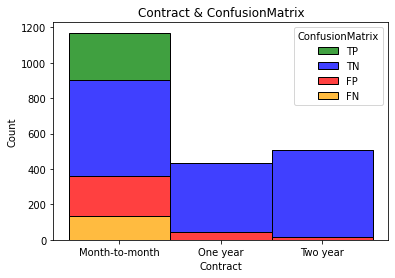

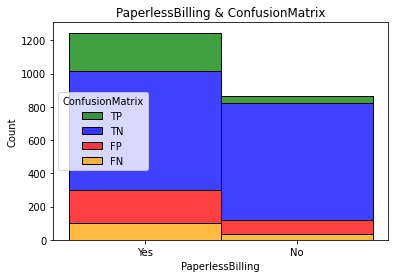

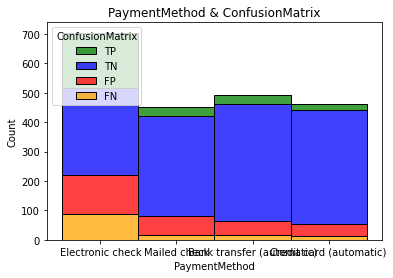

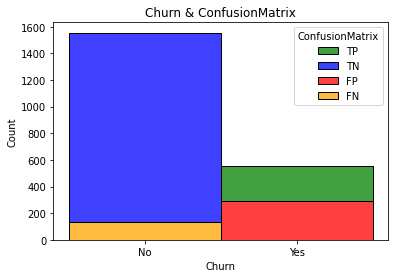

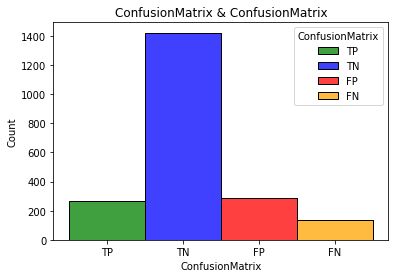

In [27]:
# See all features with 4 or less unique values and its relationship with Churning Predictions
for i, col in enumerate(df_orig.loc[:, df_orig.nunique() <= 4].columns):
    plt.figure(i)
    sns.histplot(x=col, 
                 data=df_orig, 
                 hue='ConfusionMatrix', 
                 multiple='stack',
                 palette={'TP':'green', 'TN':'blue', 'FP':'red', 'FN':'orange'}).set_title(col+' & ConfusionMatrix')


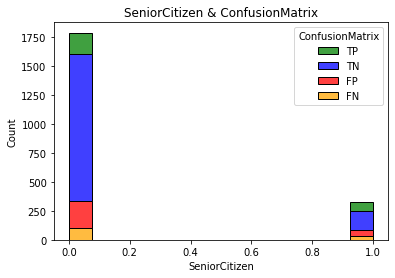

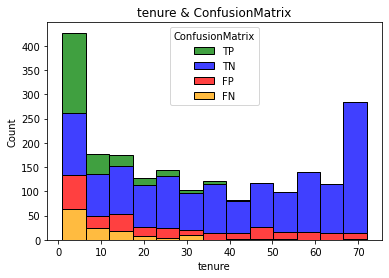

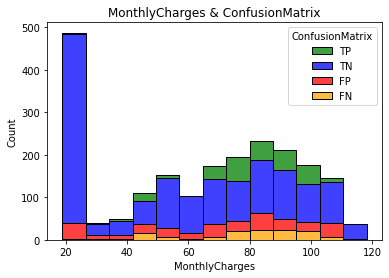

In [28]:
# Let's see how charges and tenure evaluate with customer churn
for i, col in enumerate(df_orig.select_dtypes(include=['int64','float64']).columns):
    plt.figure(i)
    sns.histplot(x=col, 
                 data=df_orig, 
                 hue='ConfusionMatrix', 
                 multiple='stack',
                 palette={'TP':'green', 'TN':'blue', 'FP':'red', 'FN':'orange'}).set_title(col+' & ConfusionMatrix')

In [29]:
# Customers likely to churn
df_orig.loc[df_orig.ConfusionMatrix == 'FN']

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,ConfusionMatrix
181,6582-OIVSP,Female,0,No,No,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,45.30,45.3,No,FN
214,2504-DSHIH,Male,1,Yes,No,23,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,No,Electronic check,86.80,1975.85,No,FN
219,6496-JDSSB,Female,0,No,No,8,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),80.00,624.6,No,FN
313,2799-ARNLO,Female,1,Yes,No,5,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,69.35,341.6,No,FN
389,5522-JBWMO,Male,0,No,Yes,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,44.00,44,No,FN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6411,5119-NZPTV,Male,1,Yes,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Electronic check,70.10,141.65,No,FN
6440,2809-ZMYOQ,Female,0,No,No,32,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,101.35,3334.9,No,FN
6467,9494-MRNYX,Male,0,No,No,10,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,No,Electronic check,75.05,786.3,No,FN
6610,9696-RMYBA,Male,0,No,No,5,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Mailed check,80.10,398.55,No,FN
